In [247]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
import matplotlib.animation as animation
from scipy.integrate import solve_bvp

### Data Engineering

In [287]:
def get_from_csv(filename):
    data = pd.read_csv(filename,index_col=0)
    return np.ravel(data.to_numpy()), data.index.to_numpy()

In [288]:
#get the data from the prescribed location
T_star, y_star = get_from_csv('../Data/1950_mean_temp.csv')
T_0, y_0 = get_from_csv('../Data/2020_mean_temp.csv')
assert np.allclose(y_star,y_0)

### Define Global Constants and Functions

In [306]:
def gen_a_fun(a_1,a_2,y_vals,M=5):
    """Generate the albedo function given the constants
    """
    def inv_acosh(x):
        m,n = np.shape(x)
        inv = np.zeros_like(x)
        overflow_mask = np.absolute(x) > 710.4
        inv[overflow_mask] = 0
        inv[~overflow_mask] = 1/np.cosh(x[~overflow_mask])
        return inv

    def a(eta):
        shape = np.shape(eta)
        one = (a_1+a_2)/2
        if (len(shape)==0):
            two = ((a_2-a_1)/2)*np.tanh(M*(y_vals-eta))
        else:
            eta = np.repeat(np.expand_dims(eta,0), len(y_vals), axis=0)
            two = ((a_2-a_1)/2)*np.tanh(M*(y_vals-eta.T).T)
        return one+two
    def d_a(eta):
        shape = np.shape(eta)
        if (len(shape)==0):
            return -1*(((a_2-a_1)*M)/2)*np.square(1/np.cosh(M*(y_vals-eta)))
        else:
            eta = np.repeat(np.expand_dims(eta,0), len(y_vals), axis=0)
            return -1*(((a_2-a_1)*M)/2)*np.square(inv_acosh(M*(y_vals-eta.T).T))
    return a, d_a

def s(y):    
    """the s function that siginifies spreading of solar
    radiation/heat across the surface
    """
    return 1 - 0.241*(3*np.square(y)-1)

def T_bar(T):
    """
    Global mean temperature computation
    """
    if (len(T.shape) == 1):
        return np.mean(T)
    else:
        return np.mean(T,axis=1)
    
def T_prime(eta,T,A):
    """
    The T_prime global equation
    """
    in_1 = (Q*S_vec*(1-a(eta).T)).T
    in_2 = A+B*T
    in_3 = C*(T_bar(T)-T.T).T
    return 1/R*(in_1 - in_2 + in_3)

def T_eta(eta,T):
    """
    For now just use the critical temperature for this condition
    """
    #get the masked y_values
    eta_r = np.repeat(np.expand_dims(eta,0), len(y_star), axis=0).T
    mask_y = y_star > eta_r
    m,n = np.shape(mask_y)
    t,y = np.shape(T)
    k_s = np.zeros(y, dtype=int)
    T_etas = np.zeros(y)
    for i in range(m):
        y_comp = y_star[mask_y[i]]
        len_add = len(y_star) - len(y_comp)
        #do the case where eta is at the pole
        if (len(y_comp) == 0):
            T_etas[i], k_s[i] = T[-1,i], len(T)-1
        #do the case where eta is at the equator
        elif (len(y_comp) == len(T)):
            T_etas[i], k_s[i] = T[0,i], 0
        else:
            k_s[i] = np.argmin(y_comp-eta[i]) + len_add
            T_etas[i] = (T[k_s[i],i]+T[k_s[i]-1,i])/2
    return k_s, T_etas
    
def T_eps_delt(T,k):
    """
    Returns the derivative with respect to T_i of T_eta
    """
    final_der = list()
    for k_val in k:
        der = list()
        #the outlier cases
        if (k_val == len(T)-1):
            der = [0 for i in range(len(T))]
            der[-1] = 1
            final_der.append(der)
            continue
        if (k_val == 0):
            der = [0 for i in range(len(T))]
            der[0] = 1 
            final_der.append(der)
            continue
        #the rest of the cases
        for i in range(len(T)):
            if (k_val == i or k_val-1 == i):
                der.append(1/2)
            else:
                der.append(0)
        final_der.append(der)
    final_der = np.asarray(final_der)
    return np.asarray(final_der)

In [307]:
#define the global constants
N = len(y_star)
n=100
t_f = n
time = np.linspace(0,t_f,n)
a_2 = 0.62
a_1 = 0.32
A_0 = 202
eta_0 = 0.8
Amax = 300
Amin = 100
beta = 1000
gamma = 200
B = 1.9
R = 12.6
C = 1.6*B
epsilon = 0.001
Q = 343
T_c = -10
#vector to be held constant
S_vec = s(y_star)
#function dependent on the eta value
a, d_a = gen_a_fun(a_1,a_2,y_star)
state0 = np.concatenate([T_0, np.array([eta_0])])
costate0 = np.zeros_like(state0)

### Solve BVP

In [310]:
def compute_A_opt(T, eta, p):
    """Computes the optimal A value based on states and costates
    """
    one=-R*p[:-1]/(2*beta)
    two=(Q*S_vec*(1-a(eta).T)).T
    three=B*T
    four=C*(T_bar(T)-T.T).T
    A_star = np.mean(one+two+three+four, axis=0)
    A = np.minimum(np.maximum(Amin,A_star),Amax)
    return A
    
def boundary_conditions(ya,yb):
    """
    Boundary conditions for the problem
    """
    condition_1 = ya[:len(y_star)]-T_0
    condition_2 = np.array([ya[len(y_star)]])
    condition_3 = yb[len(y_star)+1:]
    return np.concatenate([condition_1,condition_2,condition_3])
    
    
def states(T, Tder, Teta, state):
    """
    Computes the temperature profile update and iceline update
    using the equations in pdf
    """
    new_states = np.zeros_like(state)
    new_states[:-1] = Tder
    new_states[-1] = epsilon*(Teta-T_c)
    return new_states
    
    
def costates(T, p, Tder, Teta, k, eta):
    """
    Computes the costate updates using pdf and pontryagin's
    maximum
    """
    new_costates = np.zeros_like(p)
    TEpsDelta = T_eps_delt(T,k)
    one = (B+C)*(p[:-1] - 2*beta*Tder)
    two = C*np.mean(2*beta*Tder-p[:-1],axis=0)
    three = 2*gamma*(T.T-T_star).T
    four = p[-1]*epsilon*TEpsDelta.T
    five = (d_a(eta).T*S_vec*(p[:-1].T-2*beta*Tder.T)).T
    new_costates[:-1] = 1/R*(one+two)+three-four
    new_costates[-1] = Q/R*np.sum(five,axis=0)
    return new_costates
    
    
def optimal_climate(t,y):
    """
    function to be used in the bvp solver
    """
    y_new = np.zeros_like(y)
    state = y[:len(state0)]
    p = y[len(state0):]
    T = state[:-1]
    eta = state[-1]
    A = compute_A_opt(T,eta,p)
    Tder = T_prime(eta,T,A)
    eta = state[-1]
    Teta,k = T_eta(eta,T)
    y_new[:len(state0)] = states(T, Tder, Teta, state) 
    y_new[len(state0):] = costates(T, p, Tder, Teta, k, eta)
    return y_new
    
    
def use_solve_bvp(tf,n):
    """
    uses solve bvp to solve the system of equations
    """
    t = np.linspace(0,tf,n)
    y = np.zeros((2*len(state0),t.size))
    res = solve_bvp(optimal_climate, boundary_conditions, t, y, verbose=2, max_nodes=1000)
    return res

In [311]:
res = use_solve_bvp(1,100)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.29e+00       4.69e-24          100            117      
       2          2.44e+01       7.17e-24          217            233      
       3          1.06e+00       1.32e-23          450            464      
       4          4.41e+00       7.50e-20          914           (928)     
Number of nodes is exceeded after iteration 4. 
Maximum relative residual: 4.41e+00 
Maximum boundary residual: 7.50e-20


### Animate Temperature Profile

1
The maximum number of mesh nodes is exceeded.
4
(91, 100)


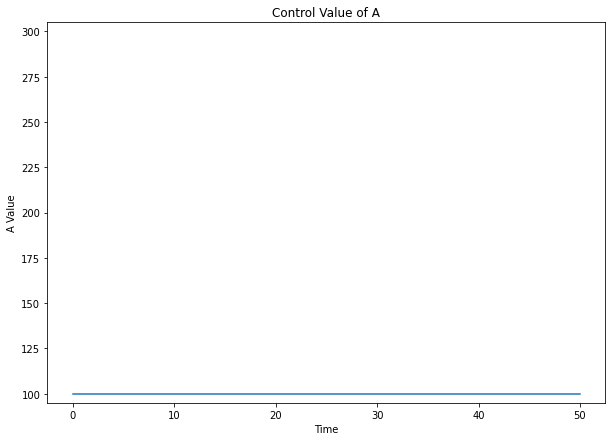

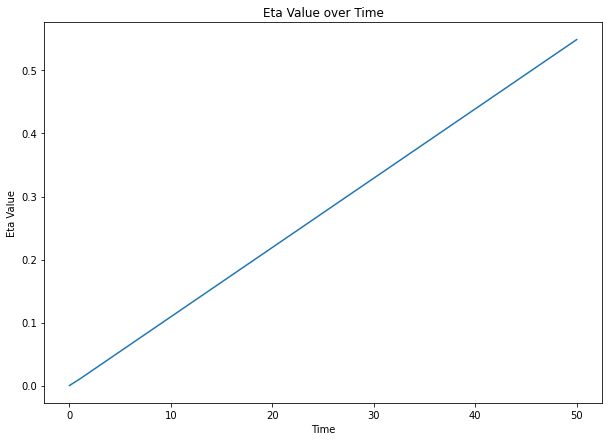

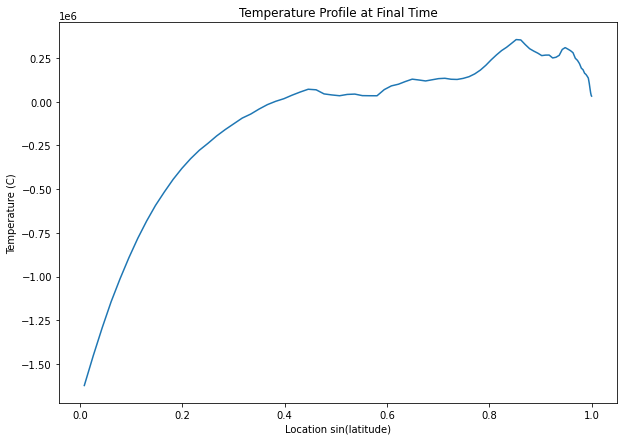

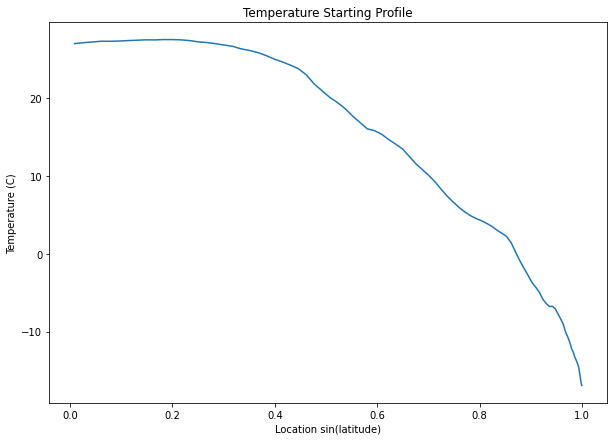

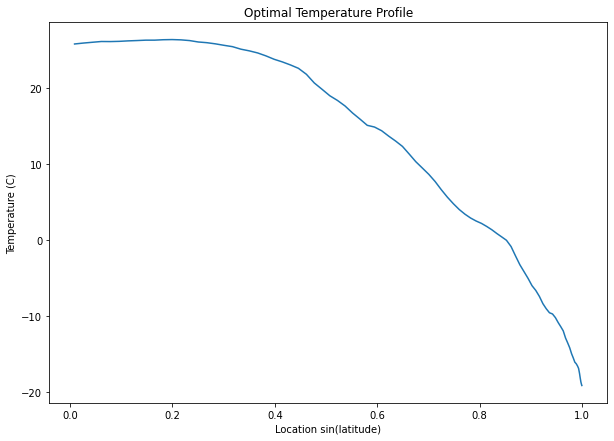

In [322]:
print(res.status)
print(res.message)
print(res.niter)
t = np.linspace(0,50,100)
params = res.sol(t)
states = params[:len(state0)]
print(states.shape)
costates = params[len(state0):]
A = compute_A_opt(states[:-1],states[-1],costates)
#plot the control solution
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(t, A)
ax.set_title("Control Value of A")
ax.set_xlabel("Time")
ax.set_ylabel("A Value")
ax.set_ylim([A_min-5,A_max+5])
plt.show()
#plot the eta solution
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(t, states[-1,:])
ax.set_title("Eta Value over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Eta Value")
plt.show()
#plot the temperature profile at a certain time
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(y_star, states[:-1,-1])
ax.set_title("Temperature Profile at Final Time")
ax.set_xlabel("Location sin(latitude)")
ax.set_ylabel("Temperature (C)")
plt.show()
#plot the starting temperature profile
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(y_star, T_0)
ax.set_title("Temperature Starting Profile")
ax.set_xlabel("Location sin(latitude)")
ax.set_ylabel("Temperature (C)")
plt.show()
#plot the optimal temperature profile
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(y_star, T_star)
ax.set_title("Optimal Temperature Profile")
ax.set_xlabel("Location sin(latitude)")
ax.set_ylabel("Temperature (C)")
plt.show()